# Nickel Cryostat Hit Efficiency

Estimating the background contributions of all components of the nEXO experiment is of paramount importance to ensure that the design meets nEXO's sensitivity requirements. In order to obtain sufficient statistics, significant computing time is then required to generate a large number of primary particles. As one solution to this problem, we have developed a new simulation procedure that significantly speeds up the computing cycles required to generate large statistics for far components. Improvements in computing speed of a factor >20x were achieved by a systematic optimization of the simulations:

1. Profiling of the simulations code identified a particularly time-consuming (but unnecessary) step in the NEST code. This was fixed in [NEST commit #5f61055](https://github.com/nEXO-collaboration/NEST/commit/5f61055f29e7a434d56356073e2ed73ea8962261).

2. Since GEANT4 uses the rejection sampling method to generate primaries in arbitrary volumes, optimizing the size of the container volume to more closely match the confining volume of interest. This is particularly time consuming for large hollow components (think Outer Cryotat). Avoiding the `/gps/confine` command altogheter further shortens computing time (~10%).

3. Outside of the TPC vessel, tracking of primary or secondary electrons (e.g. from beta decays or from photoelectric interactions) is completely unnecessary. A GEANT4 command was introduced to kill all electrons generated anywhere outside of the TPC Vessel (all `TPCExternals` components). This change was implement in PR [nexo-offile PR #246](https://github.com/nEXO-collaboration/nexo-offline/pull/246).

4. Similarly, if we are interested only in the hit efficiency in the energy ROI, then we can save computing time by kill all gammas whose energy drops outside the ROI. This option was also implemented in PR [nexo-offile PR #246](https://github.com/nEXO-collaboration/nexo-offline/pull/246). Some considerations should be kept in mind when using this feature:
   * The spectrum of gammas in the LXe will not be correct. Unless the component is very subdominant in the background budget, the resulting PDF may not be appropriate for the sensitivity fitting.
   * The multiplicity of events in the TPC might be overestimated since lower-energy coincident gammas emitted by the source are killed before they reach the LXe. Similarly, gamma returns (i.e. gammas scattering back into the LXe) are not present.

5. Charge waveform simulations underwent a significant refactoring [nexo-offile PR #233](https://github.com/nEXO-collaboration/nexo-offline/pull/233). While not many events are generated for far components, it is still worth noting.

A. Amy, Subatech, Feb 12, 2024
Credit: S. Sangiorgio, LLNL

In [1]:
# import packages
from pathlib import Path

import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import uproot as up
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist
from matplotlib.colors import LogNorm

sns.set_style("ticks")

## Simulations

We have used these new features in `nexo-offline` to simulate the background contribution from Bi214 decays
generated in the Transition Box (called `RepeaterBox` in the `nexo-offline` code). 

Simulations details:
- Number of primaries generated: 1E11 decays
- Code version: [nexo-offline commit #d556530](https://github.com/nEXO-collaboration/nexo-offline/commit/d5565302e071fe1928c43506d40741b5dc9e1816)
- As shown in the figure below, the transition box (in blue) was placed in just above the outer cryostat support, 
  about 1 meter above the outer cryostat (in green in the image). 
  The transition box is of size (18" x 12" x 12")
- Bi-214 decays were simulated in the entire box volume
- In `TPCExternals`, all electrons and gammas below 2.2 MeV are immediately killed by G4.
- Only the Geant4 and charge waveform simulations were executed. No reconstruction.
- Total computing time was ~6,500 cpu-hours.
- Data are saved on LLNL's LC at `/p/vast1/nexo/data/RepeaterBox/RepeaterBox_Bi214_100B/`


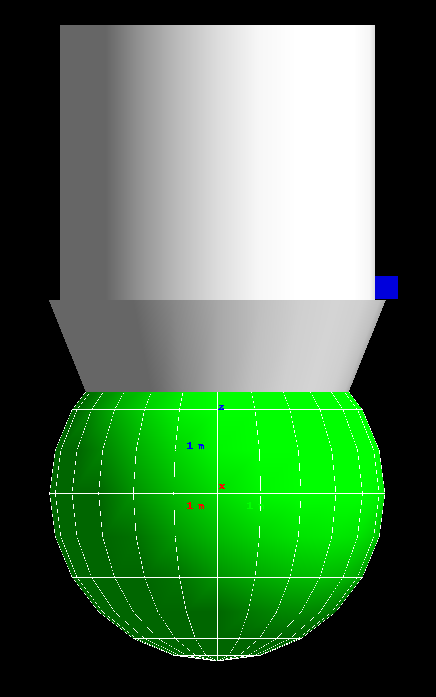


The `.mac` file that was used is provided here for reference:

```shell
# Turn on/off verbosity in various places
/run/verbose 0
/tracking/verbose 0
/control/verbose 1

/nEXO/det/checkOverlap true

# Use Baseline 2023 geometry
/control/execute ./Baseline2023.mac

/EXOPhysicsList/enableLight true

# Kill Gammas below Q value in TPCExternals (energy in keV)
# Set just above the Bi214 2204 keV gamma with 5% intensity
/analysis/setKillGammasBelowThisEnergyInTPCExternals 2205.0

# This is required for all Geant4 simulations.
/run/initialize

# Use Geant4's GPS (general particle source)
/generator/setGenerator gps

# Create an ion with Z=83, A=214 (corresponding to Bi214)
/gps/particle ion
/gps/ion 83 214
/grdm/nucleusLimits 214 214 83 83

# RepeaterBox (note no confining, generates the full box)
/gps/pos/type Volume
/gps/pos/shape Para
/gps/pos/centre 500 2250 2745.8 mm
/gps/pos/halfx 228.6  mm
/gps/pos/halfy 152.4 mm
/gps/pos/halfz 152.4 mm
```

## Data Loading

In [2]:
# Define file and directory paths
data_dir = Path(
    "/p/lustre1/amy1/nexo_offline/nexo-offline/Cards/Cryostats_background/Nickel_IV_U238/output/"
)
plot_dir = Path(
    "/p/lustre1/amy1/nexo_offline/nexo-offline/Cards/Cryostats_background/Nickel_IV_U238/plot/"
)

# Define branches to load
branches = [
    "fGenX",
    "fGenY",
    "fGenZ",
    "fTotalEventEnergy",
    "fXpos",
    "fYpos",
    "fZpos",
    "fNESTHitX",
    "fNESTHitY",
    "fNESTHitZ",
    "fNESTHitE",
]

# Get list of root files
file_list = list(data_dir.rglob("*.root"))

print(f"Files available: {len(file_list)}")

# Load and format data
events_orig = ak.to_dataframe(
    up.concatenate(
        {str(file_path): "Event/Sim/SimEvent" for file_path in file_list},
        branches,
        allow_missing=True,
        library="ak",
    )
)

# Check if events_orig is a DataFrame
if isinstance(events_orig, pd.DataFrame):
    # Define names
    events = events_orig.copy()
    events.index.names = ["event", "hit"]
else:
    print("events_orig is not a DataFrame")

Files available: 500


In [3]:
# Print the first few rows of the events DataFrame
events.head()

fGenX        fGenY      fGenZ  fTotalEventEnergy       fXpos  \
event hit                                                                      
1     0   -203.782182  1344.919815 -39.112918           0.622702 -276.960194   
      1   -203.782182  1344.919815 -39.112918           0.622702 -280.426796   
      2   -203.782182  1344.919815 -39.112918           0.622702 -286.618764   
      3   -203.782182  1344.919815 -39.112918           0.622702 -279.623862   
      4   -203.782182  1344.919815 -39.112918           0.622702 -278.796125   

                 fYpos       fZpos   fNESTHitX   fNESTHitY   fNESTHitZ  \
event hit                                                                
1     0    2067.837747  189.471456 -537.222473  154.236053 -804.478882   
      1    2068.379695  191.189495 -523.214294  144.087784 -820.621216   
      2    2067.071356  203.693250 -522.496338  144.600586 -821.492371   
      3    2063.071578  227.115257 -537.212646  154.223267 -804.477295   
      4    2063.575174  228.034726 -537.213501  154.223373 -804.477356   

           fNESTHitE  
event hit             
1     0     4.774700  
      1     4.774700  
      2     0.989500  
      3     5.416900  
      4     1.581061

## Compute and plot hit-level quantities

Since the reconstruction code is undergoind some refactoring and cannot process these simulated data, 
we developed an alternative analysis based on MC-truth information to extract an approximate hit-efficiency.  
This analysis is somewhat inspired by what was used in the [2017 sensitivity paper](https://arxiv.org/abs/1710.05075).

Our data are in a `MultiIndex` `pandas` dataframe. For now we have `events` with `hits`.

See [this documentation page](https://github.com/nEXO-collaboration/nexo-offline/blob/bc383fdd5f78181db6f630436e3c1c90b26ef920/Doc/SimEventDescription.md) 
for the meaning of the variables extracted from the `SimEvent` tree.

In [4]:
# Calculate the radial distance for each event, considering the center at (0, 0, -1022.6 mm)
events["Radius"] = np.sqrt(
    events["fGenX"] ** 2 + events["fGenY"] ** 2 + (events["fGenZ"] + 1022.6) ** 2
)

events["Radius_NESTHitR"] = np.sqrt(
    events["fNESTHitX"] ** 2
    + events["fNESTHitY"] ** 2
    + (events["fNESTHitZ"] + 1022.6) ** 2
)


events["fRpos"] = np.sqrt(
    events["fXpos"] * events["fXpos"] + events["fYpos"] * events["fYpos"]
)
events["fNESTHitR"] = np.sqrt(
    events["fNESTHitX"] * events["fNESTHitX"]
    + events["fNESTHitY"] * events["fNESTHitY"]
)

# SHOULD THIS TAKE THE CENTER OF THE CRYOSTAT INTO ACCOUNT, AND THE Z POSITION?

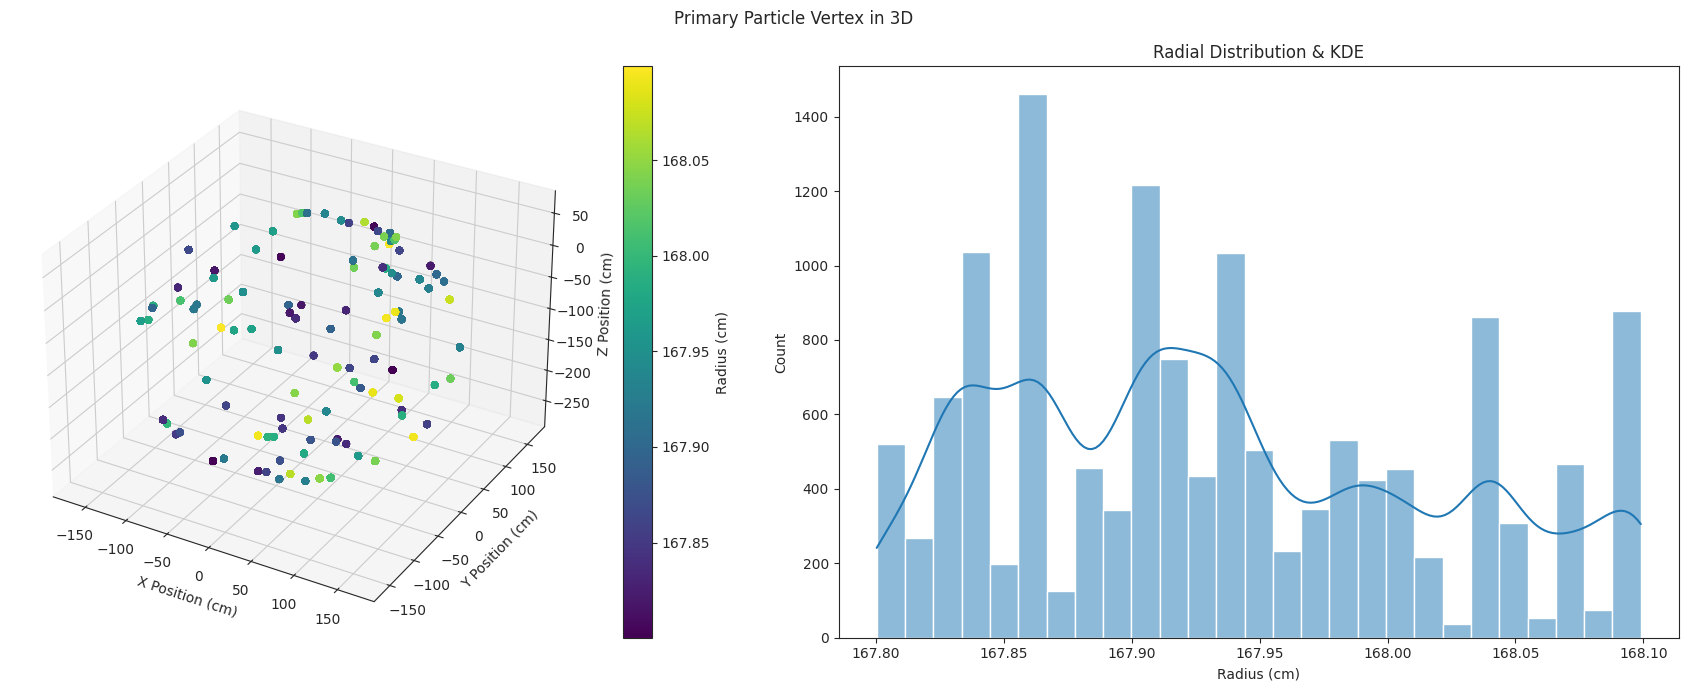

In [5]:
# Position of primaries

fig = plt.figure(figsize=(18, 7))
plt.suptitle("Primary Particle Vertex in 3D")

# Radius vs. Z position in 3D scatter plot
ax = fig.add_subplot(121, projection="3d")
p = ax.scatter(
    events["fGenX"] / 10,  # Convert X from mm to cm for plotting
    events["fGenY"] / 10,
    events["fGenZ"] / 10,
    c=events["Radius"] / 10,
    cmap="viridis",
)
ax.set_xlabel("X Position (cm)")
ax.set_ylabel("Y Position (cm)")
ax.set_zlabel("Z Position (cm)")
fig.colorbar(p, ax=ax, label="Radius (cm)")

# Histogram of Radial distribution
ax2 = fig.add_subplot(122)
sns.histplot(
    events, x=events["Radius"] / 10, kde=True, ax=ax2
)  # Convert Radius from mm to cm for histogram
ax2.set_xlabel("Radius (cm)")
ax2.set_ylabel("Count")
ax2.set_title("Radial Distribution & KDE")

plt.tight_layout()
plt.show()

These are the positions of all energy deposits. Note that energy deposits in the water are saved (if the event has energy deposits in the LXe). 

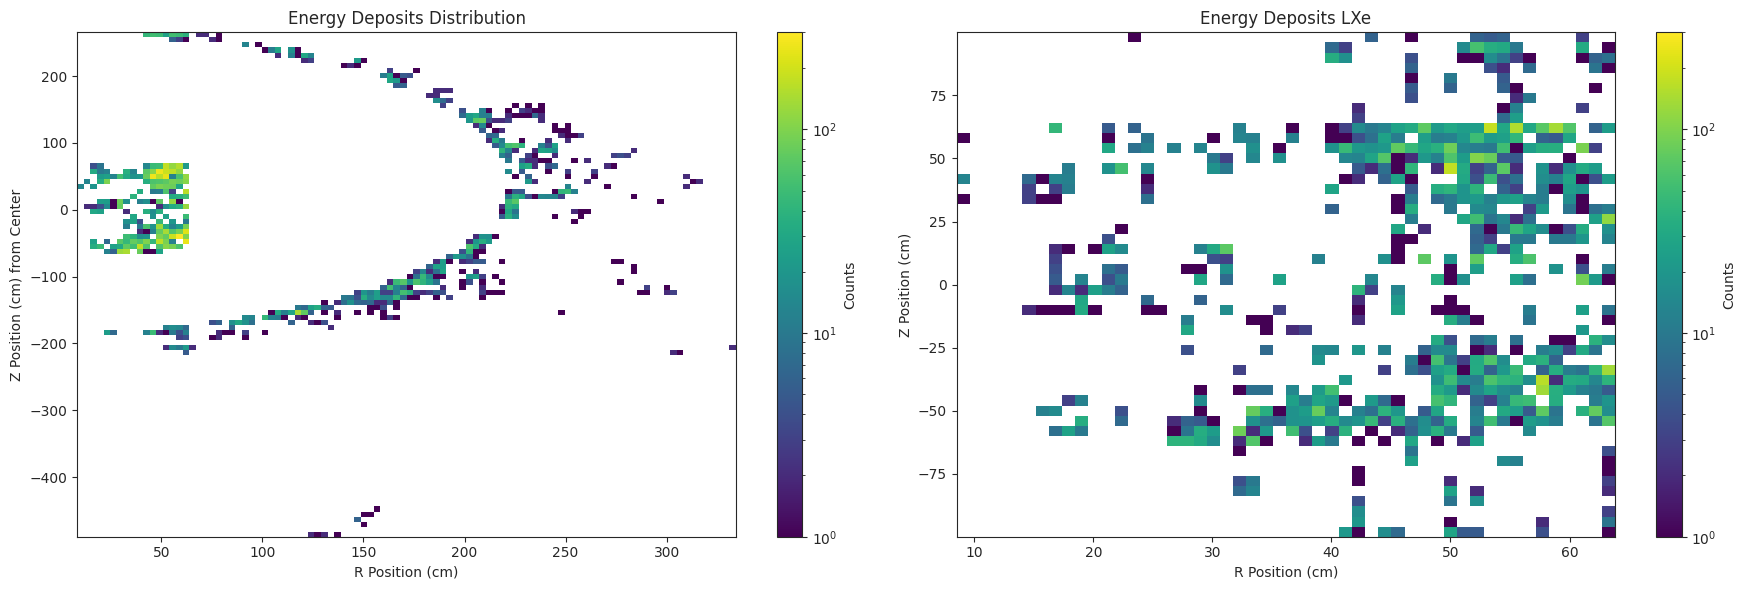

In [6]:
# Position of energy deposits

events["fZpos_adjusted"] = events["fZpos"] + 1022.6

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# First plot: Energy Deposits Distribution using hist2d
x = events["fRpos"] / 10  # Convert R position from mm to cm
y = (
    events["fZpos_adjusted"] / 10
)  # Convert Z position from mm to cm considering the real center
h = ax[0].hist2d(x, y, bins=[100, 100], cmap="viridis", norm=LogNorm(1, 300))
fig.colorbar(h[3], ax=ax[0], label="Counts")
ax[0].set_xlabel("R Position (cm)")
ax[0].set_ylabel("Z Position (cm) from Center")
ax[0].set_title("Energy Deposits Distribution")

# Second plot: Filtering for Z positions between -100 and 100 cm
filtered_events = events[
    (events["fZpos_adjusted"] > -1000) & (events["fZpos_adjusted"] < 1000)
]
x_filtered = filtered_events["fNESTHitR"] / 10  # WHY NEST HERE?
y_filtered = filtered_events["fZpos_adjusted"] / 10
h_filtered = ax[1].hist2d(
    x_filtered, y_filtered, bins=[50, 50], cmap="viridis", norm=LogNorm(1, 300)
)
fig.colorbar(h_filtered[3], ax=ax[1], label="Counts")
ax[1].set_xlabel("R Position (cm)")
ax[1].set_ylabel("Z Position (cm)")
ax[1].set_title("Energy Deposits LXe")

plt.tight_layout()
plt.show()

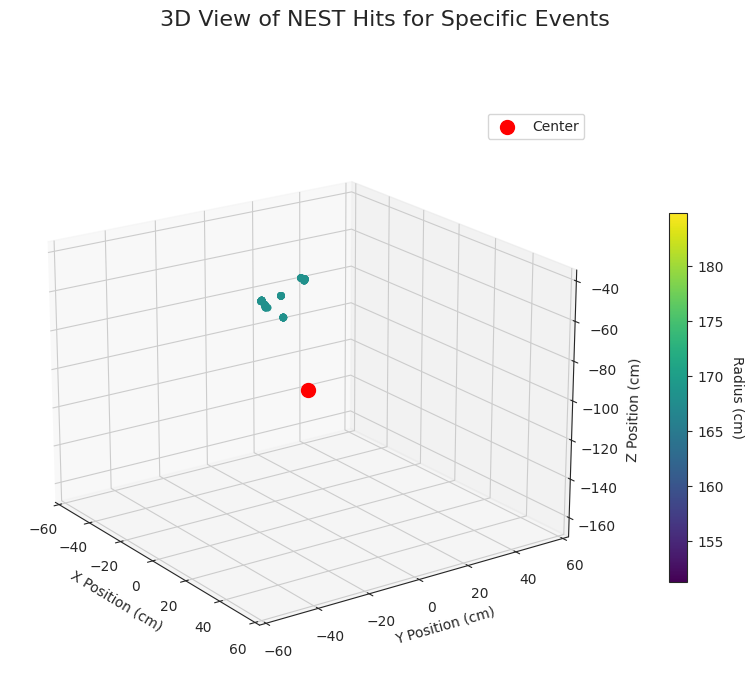

In [7]:
# Energy Deposits of a specific NEST hit
event_number = 2

# Check if the event 'event_number' exists in the dataset
if event_number not in events.index:
    print(f"Event {event_number} does not exist.")
else:
    # Create a figure for the 3D plot with adjusted layout
    fig = plt.figure(figsize=(10, 8))
    plt.suptitle("3D View of NEST Hits for Specific Events", fontsize=16)

    # Extracting the specific event's data
    event_data = events.loc[event_number]

    # Adding a 3D scatter plot for the specific event
    event_ax = fig.add_subplot(111, projection="3d")
    scatter_plot = event_ax.scatter(
        event_data["fNESTHitX"] / 10,
        event_data["fNESTHitY"] / 10,
        (event_data["fNESTHitZ"]) / 10,  # NO ADJUSTMENT FOR Z POSITION???
        c=event_data["Radius"] / 10,
        cmap="viridis",
    )

    # Marking the center of the TPC with a red dot
    event_ax.scatter(0, 0, -102.26, c="red", marker="o", s=100, label="Center")

    # Setting axis labels
    event_ax.set_xlabel("X Position (cm)")
    event_ax.set_ylabel("Y Position (cm)")
    event_ax.set_zlabel("Z Position (cm)")

    # Adjusting the view angle
    event_ax.view_init(elev=20, azim=-35)  # elev is the elevation angle in degrees

    # Adding a color bar to indicate the radius, with some adjustments to prevent overlap
    cbar = fig.colorbar(scatter_plot, ax=event_ax, shrink=0.6, aspect=20, pad=0.1)
    cbar.set_label("Radius (cm)", rotation=270, labelpad=15)

    # Adjusting the limits based on specified ranges
    event_ax.set_xlim([-60, 60])
    event_ax.set_ylim([-60, 60])
    event_ax.set_zlim([-65 - 102.26, 65 - 102.26])
    event_ax.legend()
    plt.show()

## Perform clustering

For the clustering we use `scipy` hierarchical clustering based on [the nearest point algorithm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html). It basically cluster all points that are separated by less than a threshold value from their nearest neighbor. 
We have conservatively choosen this value as `max_d`=5 mm. The [2017 sensitivity paper](https://arxiv.org/abs/1710.05075) used an algorithm based on a 3 mm radius instead.

See https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [39]:
# Define a function to cluster the hits
def clustering(X, max_d=5):  # max_d in mm
    # Nearest Point Algorithm
    Z = linkage(X, method="single", metric="euclidean")

    clusters = fcluster(Z, max_d, criterion="distance")
    return clusters


# Remove all hits outside of the TPC field cage since they are not measurable (at least not by the charge channel)
cathode_z = -1585.97
anode_z = -402.97
fieldrings_r = 566.65
mask = (
    (events.fNESTHitZ > cathode_z)
    & (events.fNESTHitZ < anode_z)
    & (events.fNESTHitR < fieldrings_r)
)
events.drop(events[~mask].index, inplace=True)

# Cluster the hits
clusters = (
    events[["fNESTHitX", "fNESTHitY", "fNESTHitZ"]]
    .groupby(level=0, axis=0, as_index=False)
    .apply(clustering)
)
clusters = clusters.explode().to_frame(name="cluster_id").reset_index()

/var/tmp/amy1/ipykernel_1491021/3825713734.py:24: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(level=0, axis=0, as_index=False)


In [43]:
# Clustered events
clustered_events = (
    events.reset_index()
    .merge(clusters[["cluster_id"]], left_index=True, right_index=True)
    .sort_values(["event", "cluster_id", "hit"])
    .set_index(["event", "cluster_id", "hit"])
)

In [44]:
# Compute energy-weighted centroids of the clusters
centroids_df = (
    clustered_events[["fNESTHitX", "fNESTHitY", "fNESTHitZ", "fNESTHitE"]]
    .groupby(level=["event", "cluster_id"], axis=0)
    .apply(
        lambda x: np.average(
            x[["fNESTHitX", "fNESTHitY", "fNESTHitZ"]], axis=0, weights=x.fNESTHitE
        )
    )
    .to_frame(name="centroids")
)
centroids_df.head()

centroids_df[["clusterX", "clusterY", "clusterZ"]] = pd.DataFrame(
    centroids_df.centroids.tolist(), index=centroids_df.index
)

clustered_events = clustered_events.merge(
    centroids_df.drop("centroids", axis=1), left_index=True, right_index=True
)

clustered_events["clusterR"] = np.sqrt(
    clustered_events.clusterX * clustered_events.clusterX
    + clustered_events.clusterY * clustered_events.clusterY
)

/var/tmp/amy1/ipykernel_1491021/1778119226.py:4: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(level=["event", "cluster_id"], axis=0)


In [16]:
# Cluster energy is the sum of all the NESTHit in that cluster

clusterE_df = (
    clustered_events[["fNESTHitE"]]
    .groupby(level=["event", "cluster_id"], axis=0)
    .sum()
    .rename(columns={"fNESTHitE": "clusterE"})
)
clustered_events = clustered_events.merge(
    clusterE_df, left_index=True, right_index=True
)

/var/tmp/amy1/ipykernel_1491021/1628786545.py:3: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(level=["event", "cluster_id"], axis=0)


## Cluster Cuts

Delete all clusters with energy less than 35 keV because they are below threshold for detection by the charge channel

In [17]:
clustered_events.drop(
    clustered_events[clustered_events.clusterE < 35].index, inplace=True
)

/var/tmp/amy1/ipykernel_1491021/1688651391.py:2: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  clustered_events.groupby(level=["event", "cluster_id"], axis=0).first(),


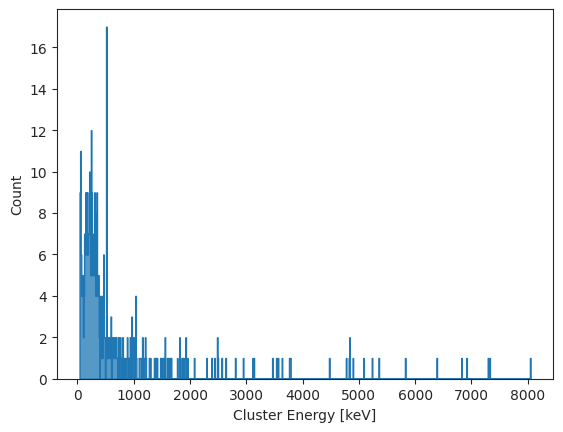

In [18]:
sns.histplot(
    clustered_events.groupby(level=["event", "cluster_id"], axis=0).first(),
    x="clusterE",
    binwidth=10,
    element="step",
)
plt.xlabel("Cluster Energy [keV]")
plt.show()

## Event Energy

The energy of the event from the sum of the energies of all the clusters within the TPC LXe (active region). 

In theory we could also apply an energy resolution smearing, but because the ROI events are so few, it could systematically
bias the result if not handled well.  It may be better to estimate conservatively the hit efficiency based on a larger ROI.

In [19]:
evTPCEnergy_df = (
    clustered_events[["clusterE"]]
    .groupby(level=["event", "cluster_id"], axis=0)
    .head(1)[["clusterE"]]
    .groupby(level="event")
    .sum()
    .rename(columns={"clusterE": "evTPCEnergy"})
)
clustered_events = clustered_events.merge(
    evTPCEnergy_df, left_index=True, right_index=True
)

/var/tmp/amy1/ipykernel_1491021/266332071.py:3: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(level=["event", "cluster_id"], axis=0)


## Number of Clusters

In [20]:
nclusters_df = (
    clustered_events.reset_index()
    .groupby(
        [
            "event",
        ],
        axis=0,
    )["cluster_id"]
    .nunique()
    .to_frame(name="nClusters")
)
clustered_events = clustered_events.merge(
    nclusters_df, left_index=True, right_index=True
)

/var/tmp/amy1/ipykernel_1491021/917839400.py:3: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(


## Standoff

In [21]:
def event_standoff(v):
    # print(v)
    x = v["clusterX"]
    y = v["clusterY"]
    z = v["clusterZ"]
    s_r = 566.65 - (x * x + y * y) ** 0.5
    z_sd = np.minimum(-402.97 - z, z + 1585.97)
    return np.amin(np.minimum(s_r, z_sd))

In [22]:
sd_df = (
    clustered_events[["clusterX", "clusterY", "clusterZ"]]
    .groupby(level=["event", "cluster_id"])
    .head(1)
    .groupby(level="event")
    .apply(event_standoff)
    .to_frame(name="evStandoff")
)
clustered_events = clustered_events.merge(sd_df, left_index=True, right_index=True)

In [23]:
def compute_event_extent(X):
    # print(X)
    dist = pdist(X)
    return max(dist)

In [24]:
extent_res = (
    clustered_events[["fNESTHitX", "fNESTHitY", "fNESTHitZ"]]
    .groupby(level="event", axis=0)
    .apply(compute_event_extent)
)
clustered_events = clustered_events.merge(
    extent_res.to_frame(name="evExtent"), left_index=True, right_index=True
)

/var/tmp/amy1/ipykernel_1491021/1539320428.py:3: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(level="event", axis=0)


Here is the final dataframe

In [25]:
clustered_events

fGenX        fGenY       fGenZ  fTotalEventEnergy  \
event cluster_id hit                                                           
1     1          0   -203.782182  1344.919815  -39.112918           0.622702   
                 3   -203.782182  1344.919815  -39.112918           0.622702   
                 4   -203.782182  1344.919815  -39.112918           0.622702   
                 5   -203.782182  1344.919815  -39.112918           0.622702   
                 6   -203.782182  1344.919815  -39.112918           0.622702   
...                          ...          ...         ...                ...   
191   3          44   235.998155  1471.575773 -248.616960           2.597571   
                 45   235.998155  1471.575773 -248.616960           2.597571   
                 46   235.998155  1471.575773 -248.616960           2.597571   
                 47   235.998155  1471.575773 -248.616960           2.597571   
                 48   235.998155  1471.575773 -248.616960           2.597571   

                            fXpos        fYpos        fZpos   fNESTHitX  \
event cluster_id hit                                                      
1     1          0    -276.960194  2067.837747   189.471456 -537.222473   
                 3    -279.623862  2063.071578   227.115257 -537.212646   
                 4    -278.796125  2063.575174   228.034726 -537.213501   
                 5    -278.754139  2063.886697   229.029387 -537.213806   
                 6    -277.363914  2054.865242   234.169591 -537.213806   
...                           ...          ...          ...         ...   
191   3          44   2001.779810   321.768782 -1570.356295  438.908875   
                 45   2001.880488   321.800075 -1570.340803  438.908081   
                 46   2003.168622   322.126805 -1569.473373  438.907196   
                 47   2002.995861   319.640043 -1571.485947  438.907990   
                 48   2002.419993   318.297177 -1571.513510  438.908081   

                       fNESTHitY   fNESTHitZ  ...  fZpos_adjusted    clusterX  \
event cluster_id hit                          ...                               
1     1          0    154.236053 -804.478882  ...     1212.071456 -537.192566   
                 3    154.223267 -804.477295  ...     1249.715257 -537.192566   
                 4    154.223373 -804.477356  ...     1250.634726 -537.192566   
                 5    154.222855 -804.477234  ...     1251.629387 -537.192566   
                 6    154.222855 -804.477234  ...     1256.769591 -537.192566   
...                          ...         ...  ...             ...         ...   
191   3          44  -138.182098 -927.857178  ...     -547.756295  438.901154   
                 45  -138.183167 -927.860474  ...     -547.740803  438.901154   
                 46  -138.182861 -927.862488  ...     -546.873373  438.901154   
                 47  -138.182983 -927.861816  ...     -548.885947  438.901154   
                 48  -138.182404 -927.861511  ...     -548.913510  438.901154   

                        clusterY    clusterZ    clusterR    clusterE  \
event cluster_id hit                                                   
1     1          0    154.231094 -804.474182  558.894470  279.886749   
                 3    154.231094 -804.474182  558.894470  279.886749   
                 4    154.231094 -804.474182  558.894470  279.886749   
                 5    154.231094 -804.474182  558.894470  279.886749   
                 6    154.231094 -804.474182  558.894470  279.886749   
...                          ...         ...         ...         ...   
191   3          44  -138.201660 -927.862610  460.145538  642.801453   
                 45  -138.201660 -927.862610  460.145538  642.801453   
                 46  -138.201660 -927.862610  460.145538  642.801453   
                 47  -138.201660 -927.862610  460.145538  642.801453   
                 48  -138.201660 -927.862610  460.145538  642.801453   

                   

## Plots

/var/tmp/amy1/ipykernel_1491021/1243251660.py:2: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  clustered_events.groupby(


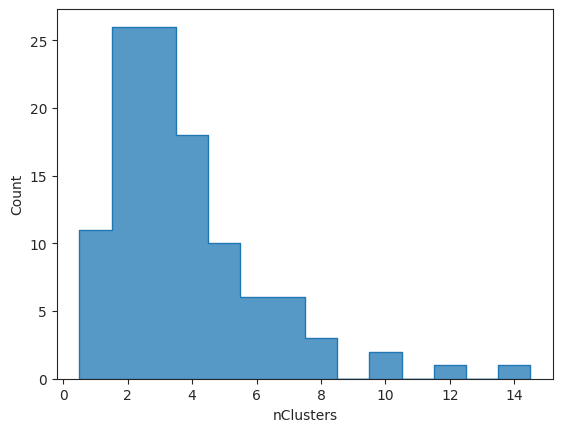

In [26]:
sns.histplot(
    clustered_events.groupby(
        level=[
            "event",
        ],
        axis=0,
    ).head(1),
    x="nClusters",
    binwidth=1,
    discrete=True,
    element="step",
)
plt.show()

/var/tmp/amy1/ipykernel_1491021/1074344393.py:2: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  clustered_events.groupby(level=["event", "cluster_id"], axis=0).head(1),


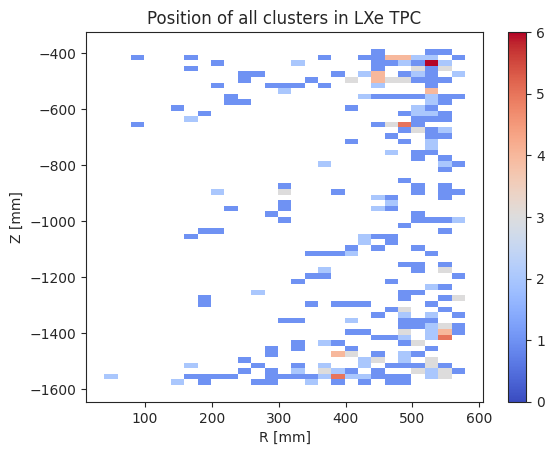

In [27]:
sns.histplot(
    clustered_events.groupby(level=["event", "cluster_id"], axis=0).head(1),
    x="clusterR",
    y="clusterZ",
    binwidth=(20, 20),
    cmap="coolwarm",
    cbar=True,
)
plt.title("Position of all clusters in LXe TPC")
plt.xlabel("R [mm]")
plt.ylabel("Z [mm]")
plt.show()

/var/tmp/amy1/ipykernel_1491021/492466359.py:3: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  clustered_events.groupby(
/var/tmp/amy1/ipykernel_1491021/492466359.py:18: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(


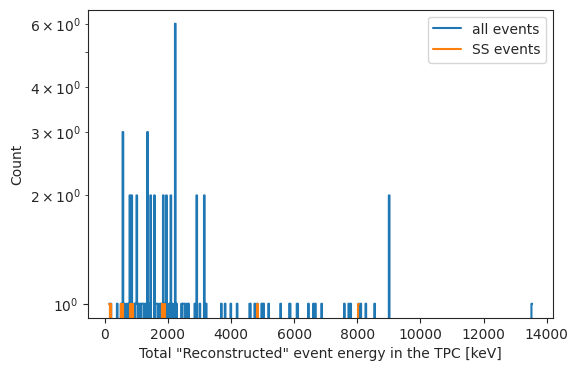

In [28]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(
    clustered_events.groupby(
        level=[
            "event",
        ],
        axis=0,
    ).head(1),
    x="evTPCEnergy",
    binwidth=20,
    ax=ax,
    label="all events",
    element="step",
    fill=False,
)
sns.histplot(
    clustered_events[clustered_events["nClusters"] == 1]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1),
    x="evTPCEnergy",
    binwidth=20,
    ax=ax,
    label="SS events",
    element="step",
    fill=False,
)
plt.xlabel('Total "Reconstructed" event energy in the TPC [keV]')
plt.legend()
plt.semilogy()
plt.show()

/var/tmp/amy1/ipykernel_1491021/4003949097.py:3: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  clustered_events.groupby(
/var/tmp/amy1/ipykernel_1491021/4003949097.py:18: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(


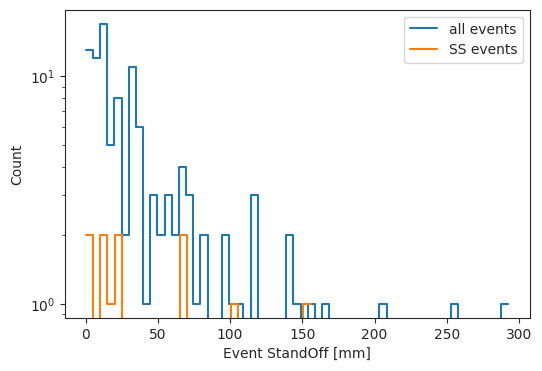

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(
    clustered_events.groupby(
        level=[
            "event",
        ],
        axis=0,
    ).head(1),
    x="evStandoff",
    binwidth=5,
    ax=ax,
    label="all events",
    element="step",
    fill=False,
)
sns.histplot(
    clustered_events[clustered_events["nClusters"] == 1]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1),
    x="evStandoff",
    binwidth=5,
    ax=ax,
    label="SS events",
    element="step",
    fill=False,
)
plt.xlabel("Event StandOff [mm]")
plt.semilogy()
plt.legend()
plt.show()

/var/tmp/amy1/ipykernel_1491021/1304962243.py:5: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(


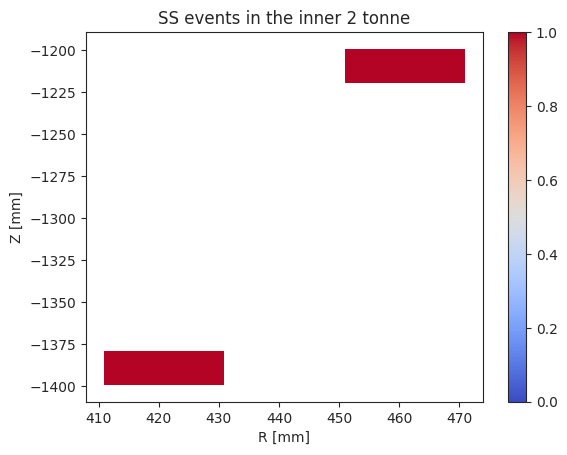

In [30]:
sns.histplot(
    clustered_events[
        (clustered_events["nClusters"] == 1) & (clustered_events["evStandoff"] > 102)
    ]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1),
    x="clusterR",
    y="clusterZ",
    binwidth=(20, 20),
    cmap="coolwarm",
    cbar=True,
)
plt.title("SS events in the inner 2 tonne")
plt.xlabel("R [mm]")
plt.ylabel("Z [mm]")
plt.show()

/var/tmp/amy1/ipykernel_1491021/2524873966.py:3: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(


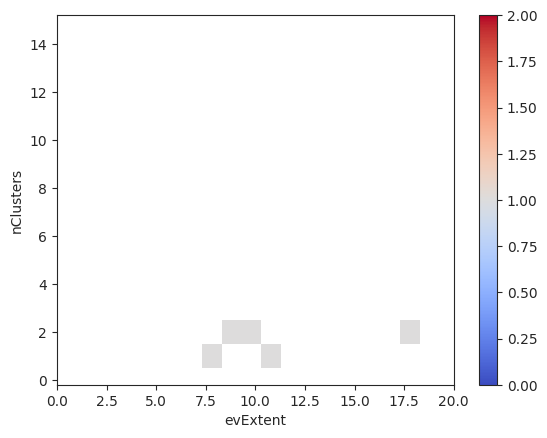

In [31]:
sns.histplot(
    clustered_events[(clustered_events.evTPCEnergy > 2000)]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1),
    x="evExtent",
    y="nClusters",
    binwidth=(1, 1),
    cmap="coolwarm",
    cbar=True,
    discrete=(False, True),
)
plt.xlim(0, 20)
plt.show()

## Results

There are no events in the inner 2 ton above 2.3 MeV, 
hence we can only set an upper limit on the hit efficiency at 90% CL as: 
$$
\epsilon < (2.3) \times 10^{-11}
$$

Once the reconstruction algorithms in `nexo-offline` have been updated, this result should be compared against that
analysis.

In [32]:
tmp = (
    clustered_events[
        (clustered_events.nClusters == 1)
        & (clustered_events.evStandoff > 102)
        & (clustered_events.evTPCEnergy > 2300)
    ]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1)[["evTPCEnergy", "evExtent", "evStandoff"]]
)
tmp.sort_values(by="evTPCEnergy", ascending=False)

/var/tmp/amy1/ipykernel_1491021/14635956.py:7: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(


,,,evTPCEnergy,evExtent,evStandoff
event,cluster_id,hit,,,
118,1,0,4833.075684,7.305204,103.572083


For reference, the total number of SS+MS events in the inner 2 ton and depositing > 2.3 MeV is only 3. 

In [33]:
tmp = (
    clustered_events[
        (clustered_events.nClusters >= 1)
        & (clustered_events.evStandoff > 102)
        & (clustered_events.evTPCEnergy > 2300)
    ]
    .groupby(
        level=[
            "event",
        ],
        axis=0,
    )
    .head(1)[
        [
            "nClusters",
            "evTPCEnergy",
            "evExtent",
            "evStandoff",
        ]
    ]
    .sort_values(by="evTPCEnergy", ascending=False)
)
len(tmp)
tmp

/var/tmp/amy1/ipykernel_1491021/4032515212.py:7: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(


,,,nClusters,evTPCEnergy,evExtent,evStandoff
event,cluster_id,hit,,,,
2,1,76,7,7597.765625,249.677133,166.059174
131,1,98,5,6601.353516,144.645090,144.119507
20,15,126,10,5844.605957,323.513816,207.655029
16,1,48,2,5181.426758,18.224455,115.065247
39,1,57,6,5028.102051,66.914716,253.535980
118,1,0,1,4833.075684,7.305204,103.572083
98,1,88,2,3699.111328,10.259039,139.271240
